# Rolling Regressions

## Imports

http://www.mit.edu/~6.s085/notes/lecture5.pdf

jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 95% -T

In [1]:
# <include-rolling_regressions/utils.py>

In [11]:
# <imports>
import numpy as np
import pandas as pd
import plotly.io as pio
from patsy import dmatrices
import statsmodels.api as sm

from rolling_regressions import utils

pio.renderers.default = "svg"
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"

In [2]:
if False:
    df_prices = utils.fetch_all_tickers([tickers] + ["SPY"], query_params={"start_date": "2016-01-01", "end_date": "2020-12-31"})
    df_prices.to_csv("df_prices.csv")
df_prices = pd.read_csv("df_prices.csv", usecols=["ticker", "date", "adj_close"]).set_index(["ticker", "date"])
data = utils.fetch_ticker("SPY", query_params={"start_date": "2016-01-01", "end_date": "2020-12-31"})
df_prices = pd.concat([df_prices, data[["ticker", "date", "adj_close"]].set_index(["ticker", "date"])], axis=0)


In [3]:
excl_tickers = ["AT"]
tickers = [s for s in df_prices.index.levels[0][:50].to_list() if s not in excl_tickers]
df_prices = df_prices.loc[tickers  + ["SPY"]].sort_index()
assert df_prices.isna().groupby("ticker").max().sum()[0] == 0

## Summary

## Analysis

Here we specify times in terms of numbers of days (which we take to be numbers of observations ignoring differences in duration between observations) and the calculate chacteristic time, $\lambda$ as $\frac{1}{\text{days}}$. We start out with inifinite series not correcting for the long small tails of the weights, even for the shorter time periods. The chart below is a bit of a simplification in that it normalizes the weights based on their sum through 360 days, excluding the weights still applicable to observations beyond 360 days, but since they are small, doing so does not alter the point of the chart. The main point is that observations well past the time $t$ continue to impact the moving average. It appears that about 65% of the statistic is comprised as a function of observations up to to $t$ with the remaining 35% coming from after that. Even at a boxcar window of $\frac{2}{\lambda}$ for 90 days results in a window of 180 days, but from the chart below that only accounts for approximately 88% of the statistic with another 12% coming from observations after 180 days.

### Potential Analyses
* Different box car window periods relative to the same characteristic times

In [5]:
times = np.array([3, 6, 10, 30, 60])
lambdas = 1 / times

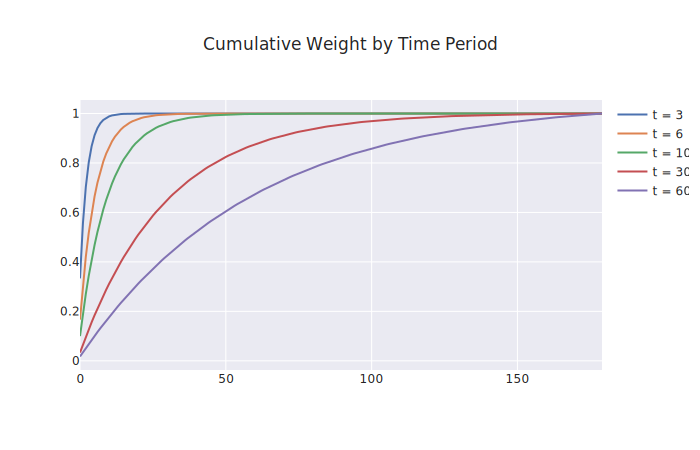

In [12]:
nobs = 180
fig = utils.go.Figure()
for t in times:
    weights = np.power(1 - 1/t, np.arange(nobs))
    weights = weights / weights.sum()
    fig.add_scatter(x=np.arange(nobs), y=pd.Series(weights).cumsum(), name=f"t = {t}")
fig.update_layout(title_text="Cumulative Weight by Time Period")
fig.show()

In [7]:
df_ret = np.log(df_prices.adj_close.unstack("ticker") / df_prices.adj_close.unstack("ticker").shift())
df_ret

ticker          AAWW       ABM      ACIW       ACM       ADP       ADS  \
date                                                                     
2016-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2016-01-05 -0.010246  0.002346 -0.003392 -0.007058  0.002434  0.008575   
2016-01-06 -0.018507 -0.009842 -0.004866 -0.015636 -0.012353 -0.014222   
2016-01-07 -0.084317 -0.021474 -0.044895 -0.030258 -0.030995 -0.030629   
2016-01-08 -0.019964 -0.005253 -0.021661 -0.018173 -0.008285 -0.019344   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.006971 -0.012910  0.013588  0.002263  0.007790  0.009768   
2020-12-28 -0.023611  0.019433 -0.008078 -0.009291  0.000283  0.006368   
2020-12-29 -0.015253 -0.019168 -0.009860  0.005791 -0.009901 -0.020493   
2020-12-30  0.011233  0.000530  0.016900  0.020009 -0.006080  0.037052   
2020-12-31 -0.001283  0.002646 -0.001560  0.006247  0.013657  0.005684   

ticker          AEGN       AEP       AES      AGCO  ...      AXAS       AZO  \
date                                                ...                       
2016-01-04       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2016-01-05 -0.009484  0.008195  0.013692  0.014341  ...  0.009217  0.004585   
2016-01-06 -0.032825  0.003734 -0.035129 -0.009243  ... -0.066375 -0.013160   
2016-01-07 -0.008791 -0.011586 -0.025234  0.000663  ... -0.106778  0.009228   
2016-01-08 -0.072666 -0.001544  0.014341 -0.004207  ...  0.035787 -0.033014   
...              ...       ...       ...       ...  ...       ...       ...   
2020-12-24  0.017291  0.008758 -0.009410 -0.004254  ... -0.022815  0.009369   
2020-12-28 -0.002601 -0.001721  0.001288 -0.010030  ... -0.023347 -0.009679   
2020-12-29 -0.021053 -0.001231  0.000429 -0.009044  ... -0.069274 -0.013082   
2020-12-30  0.009002  0.004057 -0.022999  0.009044  ...  0.008403 -0.001062   
2020-12-31  0.001054  0.021363  0.031117  0.008866  ... -0.042742  0.008106   

ticker             B        BA        BC       BCO        BG       BIG  \
date                                                                     
2016-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2016-01-05 -0.005553  0.004049 -0.012295  0.004178 -0.003598 -0.000522   
2016-01-06 -0.007649 -0.016006 -0.024221 -0.015406  0.002550 -0.013398   
2016-01-07 -0.036696 -0.042826 -0.035314 -0.033002 -0.003151 -0.006102   
2016-01-08 -0.011710 -0.022967 -0.020879 -0.019146 -0.006332 -0.015554   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003559 -0.011629 -0.005629 -0.003805 -0.006044 -0.015748   
2020-12-28  0.007277 -0.004893 -0.013964  0.009696 -0.003426  0.013290   
2020-12-29 -0.025805  0.000740 -0.029039 -0.013941 -0.010506 -0.002464   
2020-12-30  0.011198  0.001940  0.002431  0.013521  0.027212 -0.018337   
2020-12-31  0.007922 -0.012119 -0.026023  0.007248  0.005965 -0.019378   

ticker           BIO       SPY  
date                            
2016-01-04       NaN       NaN  
2016-01-05 -0.000073  0.001690  
2016-01-06 -0.010111 -0.012694  
2016-01-07 -0.021140 -0.024284  
2016-01-08 -0.011276 -0.011037  
...              ...       ...  
2020-12-24  0.001131  0.003883  
2020-12-28 -0.005370  0.008554  
2020-12-29  0.005109 -0.001910  
2020-12-30 -0.000157  0.001426  
2020-12-31  0.014010  0.005068  

[1259 rows x 50 columns]

In [8]:
nobs_oos = 6
col_list = []
for t in utils.tqdm(times):
    for s in df_ret.columns[:-1]:
        df_pair = df_ret.loc[:, [s, "SPY"]]
        for win_type, df_cov in {
            "exp_wm": df_pair.ewm(alpha=1 / t).cov(),
            "boxcar": df_pair.rolling(window=2 * t).cov(),
            "boxcar_fwd": df_pair.rolling(window=nobs_oos)
            .cov()
            .groupby("ticker")
            .shift(-nobs_oos),
        }.items():
            s_var = df_cov[s].xs(s, level=1)
            s_var.name=("var_x", win_type, f"t_{t:02d}", s)

            s_cov = df_cov[s].xs('SPY', level=1)
            s_cov.name = ("cov_xy", win_type, f"t_{t:02d}", s)
            
            col_list.extend([s_var, s_cov])

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
df_vars = pd.concat(col_list, axis=1)
df_vars.columns.names = ["stat", "win_type", "time", "ticker"]
df_vars = df_vars.stack("ticker")
df_beta = df_vars["cov_xy"].divide(df_vars["var_x"])
df_beta.columns = pd.MultiIndex.from_tuples(
    [("beta_1", *c) for c in df_beta.columns], names=["stat", "win_type", "time"]
)
df_betas = pd.concat([df_vars, df_beta], axis=1)
df_betas = df_betas.swaplevel("stat", "win_type", axis=1)
df_betas = df_betas.sort_index(axis=1)

win_type        exp_wm        boxcar    boxcar_fwd
stat            beta_1        beta_1        beta_1
time              t_03          t_03          t_03
count     61103.000000  61103.000000  61103.000000
mean          0.246709      0.251913      0.249366
std           0.289689      0.325640      0.323415
min          -5.389845     -8.037017     -8.037017
25%           0.056988      0.052298      0.051189
50%           0.195166      0.199398      0.197478
75%           0.388455      0.406066      0.402924
max           3.404539      7.904222      7.904222


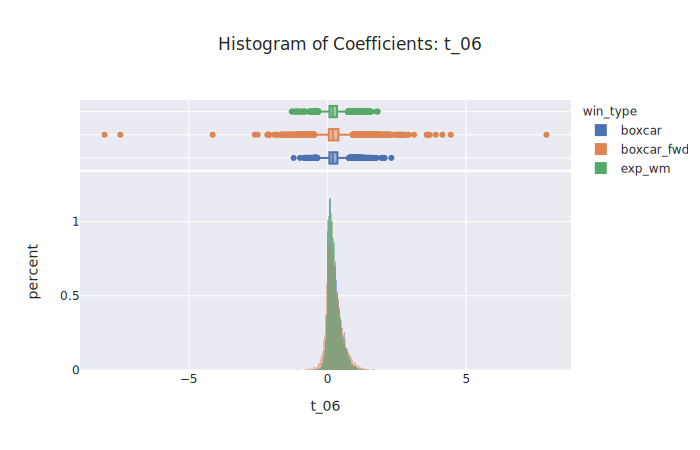

win_type        exp_wm        boxcar    boxcar_fwd
stat            beta_1        beta_1        beta_1
time              t_06          t_06          t_06
count     60809.000000  60809.000000  60809.000000
mean          0.235811      0.240742      0.248262
std           0.223510      0.236277      0.322786
min          -1.283109     -1.215746     -8.037017
25%           0.077175      0.072734      0.050564
50%           0.187682      0.191679      0.196543
75%           0.349876      0.362687      0.401681
max           1.818789      2.309311      7.904222


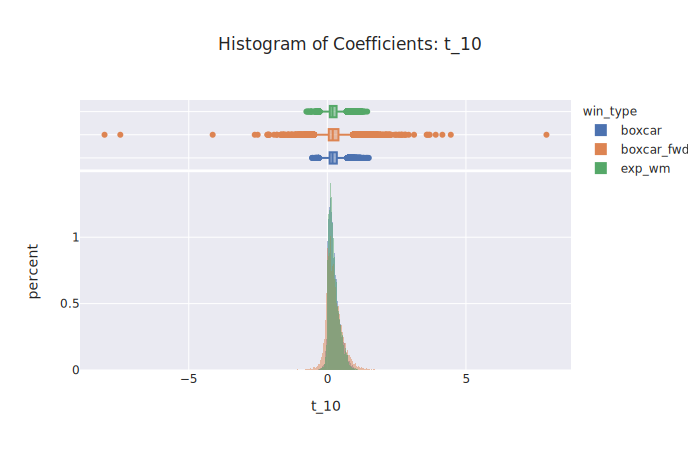

win_type        exp_wm        boxcar    boxcar_fwd
stat            beta_1        beta_1        beta_1
time              t_10          t_10          t_10
count     60417.000000  60417.000000  60417.000000
mean          0.230948      0.233072      0.247252
std           0.196124      0.204363      0.322653
min          -0.755332     -0.551602     -8.037017
25%           0.089273      0.083161      0.050000
50%           0.185769      0.187236      0.195404
75%           0.333877      0.341907      0.400363
max           1.438075      1.495626      7.904222


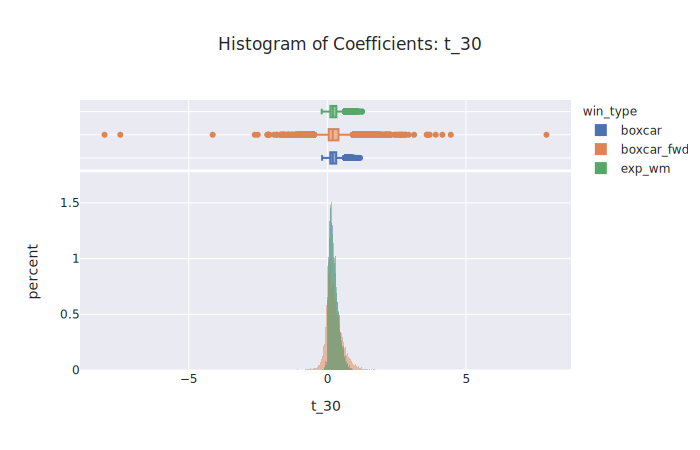

win_type        exp_wm        boxcar    boxcar_fwd
stat            beta_1        beta_1        beta_1
time              t_30          t_30          t_30
count     58457.000000  58457.000000  58457.000000
mean          0.232025      0.228145      0.247341
std           0.162027      0.165944      0.323253
min          -0.202692     -0.188333     -8.037017
25%           0.110595      0.105138      0.048735
50%           0.199319      0.193975      0.194160
75%           0.323770      0.319182      0.400902
max           1.253052      1.179788      7.904222


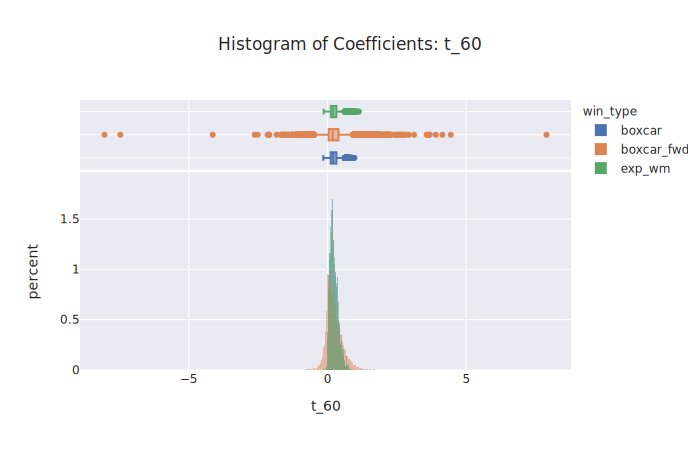

win_type        exp_wm        boxcar    boxcar_fwd
stat            beta_1        beta_1        beta_1
time              t_60          t_60          t_60
count     55517.000000  55517.000000  55517.000000
mean          0.238992      0.237955      0.246771
std           0.150015      0.152288      0.323729
min          -0.129974     -0.146106     -8.037017
25%           0.126155      0.123075      0.047034
50%           0.212479      0.211475      0.192139
75%           0.325334      0.326784      0.400443
max           1.138126      0.976441      7.904222


In [13]:
time = times[0]
for time in times:
    df_select = df_betas[[("exp_wm", "beta_1", f"t_{time:02d}"), ("boxcar", "beta_1", f"t_{time:02d}"), ("boxcar_fwd", "beta_1", f"t_{time:02d}")]].dropna()
    fig = utils.px.histogram(df_select.stack(["win_type", "stat"]).reset_index(), x=f"t_{time:02d}", color="win_type", barmode="overlay", title=f"Histogram of Coefficients: t_{time:02d}", histnorm="percent", marginal="box", height=600)
    fig.show()
    print(df_select.describe())

In [12]:
df_betas.head()

win_type          boxcar                                                 ...  \
stat              beta_1                     cov_xy                      ...   
time                t_03 t_06 t_10 t_30 t_60   t_03 t_06 t_10 t_30 t_60  ...   
date       ticker                                                        ...   
2016-01-04 AAWW      NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  ...   
           ABM       NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  ...   
           ACIW      NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  ...   
           ACM       NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  ...   
           ADP       NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  ...   

win_type          exp_wm                                                
stat              cov_xy                     var_x                      
time                t_03 t_06 t_10 t_30 t_60  t_03 t_06 t_10 t_30 t_60  
date       ticker                                                       
2016-01-04 AAWW      NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  
           ABM       NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  
           ACIW      NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  
           ACM       NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  
           ADP       NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  

[5 rows x 45 columns]

In [ ]:
print(df_betas[[("boxcar", "beta_1", f"t_{time:02d}"), ("boxcar_fwd", "beta_1", "t_05"), ("exp_wm", "beta_1", f"t_{time:02d}")]].loc[ticker].dropna().describe())

As a check to makes sure the that the calculations appear to be being performed correctly we can plot one ticker, SPY and the variance and covariance. This looks like its doing the right thing - the 90 day moving average with much more muted responses to changes in AAPL variance.

In [ ]:
fig = utils.make_subplots(specs=[[{"secondary_y": True}]])
fig.add_scatter(x=df_betas.index.levels[1], y=df_prices.loc["AAPL"].adj_close, name="AAPL")
fig.add_scatter(x=df_betas.index.levels[1], y=df_betas.loc["AAPL"].exp_wm.var_x.t_05, name="t_05", secondary_y=True)
fig.add_scatter(x=df_betas.index.levels[1], y=df_betas.loc["AAPL"].exp_wm.var_x.t_90, name="t_90", secondary_y=True)
fig.update_layout(title="EWM Variance", showlegend=True)

Covariance appears to be working as well.

In [ ]:
fig = utils.make_subplots(specs=[[{"secondary_y": True}]])
fig.add_scatter(x=df_betas.index.levels[1], y=df_prices.loc["AAPL"].adj_close / df_prices.loc["AAPL"].adj_close.iloc[0] * 100, name="AAPL") 
fig.add_scatter(x=df_betas.index.levels[1], y=df_prices.loc["SPY"].adj_close / df_prices.loc["SPY"].adj_close.iloc[0] * 100, name="SPY", line=dict(color=utils.COLORS[3]))
fig.add_scatter(x=df_betas.index.levels[1], y=df_betas.loc["AAPL"].cov_xy.t_05, name="cov_xy.t_05", secondary_y=True, line=dict(color=utils.COLORS[1]))
fig.add_scatter(x=df_betas.index.levels[1], y=df_betas.loc["AAPL"].cov_xy.t_90, name="cov_xy.t_90", secondary_y=True, line=dict(color=utils.COLORS[2]))
fig.update_layout(title="EWM Covariance", showlegend=True)

This can be simplified with the calculation of ewma above by just calcing the var and covs and the rest is the same.

In [ ]:
col_list = []
for t in times:
    s_var = pd.Series((np.concatenate(np.repeat(np.expand_dims(np.eye(len(df_ret.columns)), axis=0), len(df_ret.index), axis=0), axis=0) * df_ret.rolling(window=2 * t).cov()).sum(axis=1), name=("var_x", f"t_{t:02d}"))
    s_cov = df_ret.rolling(window=2 * t).cov()["SPY"]
    s_cov.name = ("cov_xy", f"t_{t:02d}")
    col_list.extend([s_var, s_cov])
df_vars = pd.concat(col_list, axis=1)
df_vars = df_vars.loc[df_vars.index.get_level_values("ticker") != "SPY"]
df_vars.columns.names = ["stat", "time"]

df_beta = df_vars["cov_xy"].divide(df_vars["var_x"])
df_beta.columns = pd.MultiIndex.from_tuples([("beta_1", c) for c in df_beta.columns], names=["stat", "time"])

df_betas = pd.concat([df_vars, df_beta], axis=1)
df_betas = df_betas.sort_index(axis=1)
df_betas.index = df_betas.index.swaplevel()
df_betas = df_betas.sort_index()
df_betas.loc["AAPL"].head(60)

### Forward Looking 5 Box Car Coefficients

In [ ]:
df_ret.loc["2020-04-27":"2020-05-11"]

In [ ]:
res = sm.OLS.from_formula(y, X)
res.summary()

In [ ]:
df_cov = df_ret.loc["2020-04-27":"2020-05-11"].cov()
df_cov

In [ ]:
beta = df_cov.SPY.iloc[1] / df_cov.SPY.iloc[0]
beta

In [ ]:
len(df_ret.loc["2020-04-27":"2020-05-11"])

In [ ]:
df_ret

In [ ]:
cov_SPY_SUN = (df_ret.loc["2020-04-27":"2020-05-11"] - df_ret.loc["2020-04-27":"2020-05-11"].mean()).prod(axis=1).sum() / 10
cov_SPY_SUN

In [ ]:
var_SPY_SUN = (df_ret.loc["2020-04-27":"2020-05-11"] - df_ret.loc["2020-04-27":"2020-05-11"].mean()).pow(2).sum() / 10
var_SPY_SUN

In [ ]:
df_ret.loc["2020-04-27":"2020-05-11"].mean().SUN - beta * df_ret.loc["2020-04-27":"2020-05-11"].mean().SPY

## Check to see if